In [28]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import trapz

from IPython.core.display import HTML

# Loading the pre-calculated eigenvalues

In [29]:
α = np.load('eigenvalues.npy')

N = 101

m = np.linspace(0, 1, N)
r = np.linspace(0, .1, N)

For single report and determination of $\tilde{m}, \tilde{r}, \beta$ from input frequencies $f$ see last cell's of the notebeook.

Only the first three modes are visible in frequency spectrum which are used to determine $\tilde{m}$ and $\tilde{r}$

In [46]:
# custom probe 
f = np.array([3494, 27350, 78960])

# Functionalized AFM probes for force spectroscopy: eigenmode shapes and stiffness 
# calibration through thermal noise measurements (2013) J. Laurent
# f = np.array([10974, 83050, 246380])

# loss function

$$
\mathcal{L} = \sqrt{\frac{1}{n-1}\sum_{i=2}^n\left(\frac{\alpha_i}{\alpha_1} - \sqrt{\frac{f_i}{f_1}}\right)^2}
$$

In [47]:
def loss(α, f):
    # RMSE
    return np.sqrt(np.mean((α[1:]/α[0] - np.sqrt(f[1:]/f[0]))**2))

Calculating the loss

In [97]:
L = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        L[i,j] = loss(α[i,j], f)

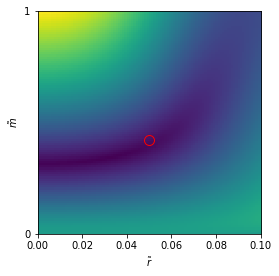

In [98]:
plt.matshow(L, extent=(0,.1,0,1), origin='lower', aspect=r.max()/m.max())

plt.plot(rb, mb, 'ro', ms=10, markerfacecolor='none')

plt.xlabel(r'$\tilde{r}$')
plt.ylabel(r'$\tilde{m}$')
plt.gca().xaxis.tick_bottom()

In [99]:
def pct_deviation(αb, f):
    return ((αb/αb[0] - np.sqrt(f/f[0])) / np.sqrt(f/f[0]) * 100).round(3)

In [100]:
min_i, min_j = np.unravel_index(np.argmin(L), L.shape)

mb, rb = m[min_i], r[min_j]
αb = α[min_i,min_j]

HTML(f'$\\tilde{{m}}_\\textrm{{best}}={mb}$; $\\tilde{{r}}_\\textrm{{best}}={rb}$')

In [101]:
pct_deviation(αb, f)

array([ 0.   ,  0.05 , -0.004])

In [102]:
def beta(α, m, r, min_i, min_j, x=1):
    mb = m[min_i]
    rb = r[min_j]
    α1 = α[min_i, min_j, 0]
    
    A = np.sin(α1) - np.sinh(α1) + α1*mb*(np.cos(α1) - np.cosh(α1))
    B = np.cos(α1) + np.cosh(α1) - α1*mb*(np.sin(α1) - np.sinh(α1))

    R = A/B
    R2 = R**2
    
    # normalization factor
    x_num = np.linspace(0,1,100)
    z_num = np.cos(α1*x_num) - np.cosh(α1*x_num) + R*(np.sin(α1*x_num) - np.sinh(α1*x_num))
    
    dzdx_num = α1*(-np.sin(α1)-np.sinh(α1)+R*(np.cos(α1)-np.cosh(α1)))
    # numerical
    A1 = 1 / np.sqrt(trapz(z_num**2, x_num) + mb*z_num[-1]**2 + mb*rb**2*dzdx_num**2)
        
    # dynamic deflection slope
    dzdx_d = A1*α1*(-np.sin(α1*x)-np.sinh(α1*x)+R*(np.cos(α1*x)-np.cosh(α1*x)))
    # static deflection slope
    dzdx_s = (6*x-3*x**2)/2

    beta =  3/(α1**4) * (dzdx_d/dzdx_s)**2

    return beta

beta(α, m, r, min_i, min_j)

0.9303098416527786

In [103]:
δm = m[1]-m[0]
δr = r[1]-r[0]

β = beta(α, m, r, min_i, min_j)
δβ = np.sqrt((beta(α,m,r,min_i+1,min_j) - β)**2  + (beta(α,m,r,min_i,min_j+1) - β)**2)

HTML(f'$\\beta^*=({β:.3f}\pm{np.ceil(δβ*1000)/1000:.3f})$')

# All-in-one calculation for given frequencies $f$

In [94]:
def characterize(f, α, m, r, x=1):
    L = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            L[i,j] = loss(α[i,j], f)
            
    min_i, min_j = np.unravel_index(np.argmin(L), L.shape)
                
    β = beta(α, m, r, min_i, min_j, x)
    δβ = np.sqrt((beta(α,m,r,min_i+1,min_j) - β)**2  + (beta(α,m,r,min_i,min_j+1) - β)**2)
    
    plt.matshow(L, extent=(0,r.max(),0,m.max()), origin='lower', aspect=r.max()/m.max())
    plt.plot(r[min_j], m[min_i], 'ro', ms=10, markerfacecolor='none')
    plt.xlabel(r'$\tilde{r}$')
    plt.ylabel(r'$\tilde{m}$')
    plt.gca().xaxis.tick_bottom()
    plt.show()
    
    return HTML(
        f'$\\tilde{{m}}=({m[min_i]}\pm{m[1]-m[0]})$; $\\tilde{{r}}=({r[min_j]}\pm{r[1]-r[0]})$; '
        f'<br>$\\beta^*=({β:.3f}\pm{np.ceil(δβ*1000)/1000:.3f})$'
        f'<br> Deviation [%] : ' + ', '.join([str(round(e,3)) for e in pct_deviation(α[min_i,min_j], f)[1:]])
    )

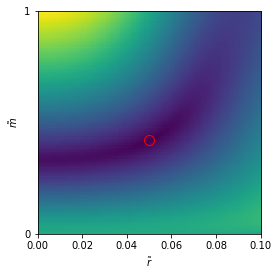

In [95]:
# custom probe
f = np.array([3494, 27350, 78960])
characterize(f, α, m, r)

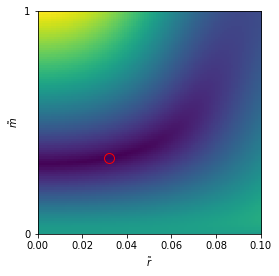

In [104]:
# Functionalized AFM probes for force spectroscopy: eigenmode shapes and stiffness 
# calibration through thermal noise measurements (2013) J. Laurent
f = np.array([10974, 83050, 246380])
characterize(f, α, m, r)

Paper estimates $\tilde{m}=0.35$ and $\tilde{r}=0.3$ having deviations 0.4%, -0.5%.